### Introduction: Comparing Solutions of the 1D Wave Equation with a Smaller PINN Model

---

In this notebook, we will explore the performance of a smaller Physics-Informed Neural Network (PINN) model in solving the 1D wave equation. The focus of this analysis is to understand the capability of the PINN in capturing the dynamics of wave propagation with a reduced model architecture and to compare the predicted results with the analytical solution.

#### Objectives

1. **Loading Pre-Trained Weights**:
   - We will load the pre-trained weights from a smaller PINN model stored as checkpoints on Google Drive. This model has been previously trained on the 1D wave equation dataset, incorporating initial and boundary conditions.

2. **Comparison with Analytical Solution**:
   - The analytical solution of the 1D wave equation provides an exact reference to evaluate the accuracy of the PINN's predictions. We will compare the model's outputs with the analytical solution at various time steps to assess its performance.

3. **Visualization and Analysis**:
   - Visualizations will be used to compare the predicted waveforms and the analytical solution, highlighting any discrepancies or errors. We will also discuss potential reasons for differences and consider the impact of the smaller model's architecture on its predictive accuracy.

#### Key Components

- **Checkpoint Loading**: We will utilize TensorFlow's checkpointing mechanisms to load the model's weights from Google Drive, ensuring that we start from a trained state without re-training.
- **Solution Comparison**: The PINN's predictions will be compared with the analytical solution at multiple time steps, providing insights into the model's strengths and limitations.
- **Model Evaluation**: Metrics such as the L2 norm difference will be used to quantify the deviation of the model's predictions from the analytical solution, offering a clear measure of accuracy.

#### Background

The 1D wave equation, represented by the partial differential equation:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

is a fundamental equation describing wave propagation in a medium. In this analysis, we aim to assess how well a smaller PINN model, with fewer layers and neurons, can approximate the solution to this equation compared to the exact analytical solution.

#### Prerequisites

To follow along, you should be familiar with:
- Basic concepts of neural networks and machine learning.
- Fundamental principles of differential equations, particularly the wave equation.
- Python programming and TensorFlow library usage.

By the end of this notebook, you will have a comprehensive understanding of the performance of smaller PINN models in solving complex PDEs, along with practical insights into model evaluation and comparison with analytical solutions.

In [1]:
# Setup google drive to access the trained weights
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Weights location
checkpoint_dir = '/content/drive/My Drive/checkpoints_small'

#### Key Considerations
Consistency in Model Architecture: It is crucial to ensure that the architecture of the PINN model used here matches the one employed during training. Any deviations could result in incorrect predictions or failed weight restoration.

#### Reference to Previous Notebook
This notebook builds on the work done in the previous notebook, where the training process and model setup were described in detail. Here, we focus solely on the solution comparison aspect, assuming the model has already been trained and the weights are available.

#### Overview
Problem Parameters: The same physical parameters used during training are defined here, including the length of the string $L$, wave speed $c$, amplitude of the initial displacement $A$, and total time duration $T$.

#### Model Architecture
The neural network architecture is defined to be identical to the one used during training. This includes the number of layers and neurons, activation functions, and output configuration.

#### Analytical Solution
An analytical solution for the 1D wave equation is provided for comparison. This exact solution serves as a benchmark to evaluate the accuracy of the PINN model's predictions.

By maintaining consistency in the model architecture and parameters, and referencing the analytical solution, this notebook provides a focused evaluation of the smaller PINN model's performance in capturing the wave dynamics accurately.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the problem parameters
L = 1.0      # Length of the string
c = 1.0      # Wave speed
A = 0.1      # Amplitude of the initial displacement
T = 1.0      # Total time duration

# Define the neural network architecture (same as the training model)
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense5 = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.dense5(x)

# Create an instance of the PINN model
model = PINN()

# Define the analytical solution for comparison
def analytical_solution(x, t, L, c, A):
    omega = np.pi * c / L
    return A * np.sin(np.pi * x / L) * np.cos(omega * t)

### Restoring the Model Checkpoint

---

To ensure that our solution comparison uses the most up-to-date model, we restore the latest checkpoint saved during training. This step is crucial as it loads the model weights, allowing us to leverage the training progress made previously.

```python
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint).expect_partial()
    print(f"Model restored from checkpoint: {manager.latest_checkpoint}")
else:
    print("No checkpoint found. Exiting.")
    exit()
```

This code ensures that the model is correctly initialized with the saved weights, ready for the solution comparison against the analytical results. If no checkpoint is found, the script exits to prevent running with uninitialized weights.

In [4]:
# Restore the latest checkpoint
# checkpoint_dir = './checkpoints'
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint).expect_partial()
    print(f"Model restored from checkpoint: {manager.latest_checkpoint}")
else:
    print("No checkpoint found. Exiting.")
    exit()

Model restored from checkpoint: /content/drive/My Drive/checkpoints_small/ckpt-10


### Solution Comparison and Visualization

---

In this section, we compare the solutions obtained from the Physics-Informed Neural Network (PINN) with the analytical solution of the 1D wave equation. We evaluate the performance of the model at various time points by computing the L2 norm difference between the predicted and analytical solutions and visualizing the results.

#### Defining the Grid and Time Points

We start by defining the spatial grid and specific time points at which we want to evaluate the solutions:

```python
nx = 100
x_vals = np.linspace(0, L, nx)
times = [0.0, 0.25, 0.75, 1.0]
```

- **`nx`**: Number of spatial points along the length of the string.
- **`x_vals`**: Array of spatial coordinates, evenly spaced from 0 to $L$.
- **`times`**: List of time points at which we will compare the solutions. These include the initial time and other points within the total time duration $T$.

#### Computing and Visualizing the Solutions

For each specified time point, we compute the wave function using both the PINN model and the analytical solution, then visualize and compare the results.

```python
L2_norm_diffs = []

for t in times:
    t_vals = t * np.ones_like(x_vals)
    inputs = np.column_stack((x_vals, t_vals))

    # Ensure inputs are in the correct shape and dtype
    inputs_tf = tf.convert_to_tensor(inputs, dtype=tf.float32)
    u_pinn = model(inputs_tf).numpy().flatten()  # Ensure model output is flattened
    u_analytical = analytical_solution(x_vals, t, L, c, A).flatten()

    # Compute the L2 norm difference
    numerator = np.sum((u_pinn - u_analytical)**2)
    denominator = np.sum(u_pinn**2)
    L2_norm_diff = np.sqrt(numerator / denominator)
    L2_norm_diffs.append(L2_norm_diff)

    # Plotting
    plt.figure()
    plt.plot(x_vals, u_analytical, label='Analytical')
    plt.plot(x_vals, u_pinn, label='PINN', linestyle='dashed')
    plt.title(f"Solution Comparison at t = {t}")
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(-0.1, 0.1)
    plt.show()
```

- **Input Preparation**: For each time point $t$, we create an array of time values `t_vals` matching the spatial points. These are combined with `x_vals` to form the inputs to the model, ensuring they are correctly shaped and converted to TensorFlow tensors.

- **Model Prediction and Analytical Solution**: We obtain the predicted wave function values `u_pinn` from the PINN model and the exact values `u_analytical` from the analytical solution. The analytical solution is defined as:

$$
u(x, t) = A \sin\left(\frac{\pi x}{L}\right) \cos\left(\frac{\pi c t}{L}\right)
$$

- **L2 Norm Difference**: The L2 norm difference quantifies the error between the PINN's predictions and the analytical solution:

$$
\text{L2 norm difference} = \sqrt{\frac{\sum (u_{\text{PINN}} - u_{\text{analytical}})^2}{\sum u_{\text{PINN}}^2}}
$$

This metric provides a normalized measure of the model's accuracy.

- **Visualization**: We plot the analytical solution and the PINN predictions for each time point. The plots visually compare the two solutions, highlighting any discrepancies. The use of solid lines for the analytical solution and dashed lines for the PINN predictions helps distinguish between them.

This detailed comparison at multiple time points provides insights into the PINN model's performance and its ability to approximate the true solution of the 1D wave equation.

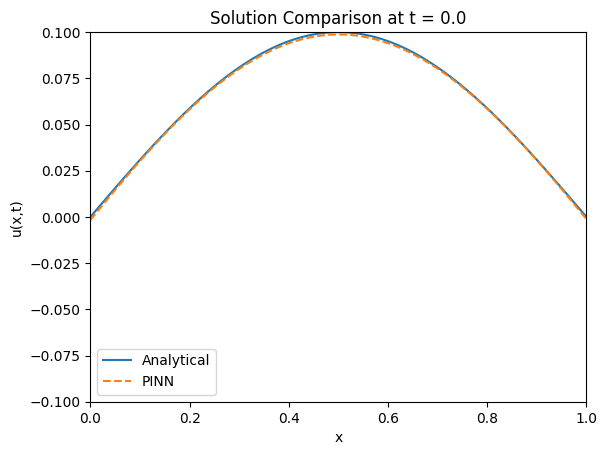

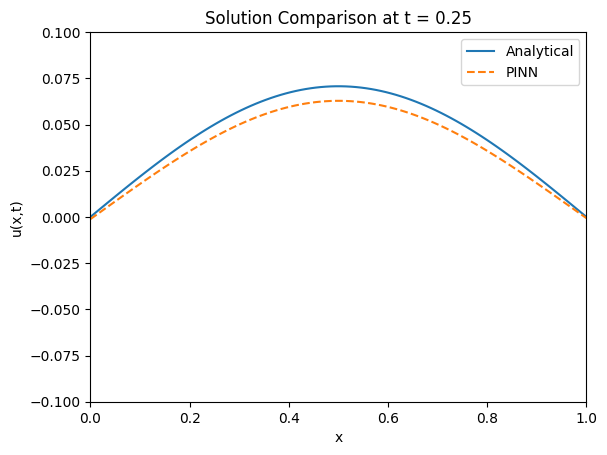

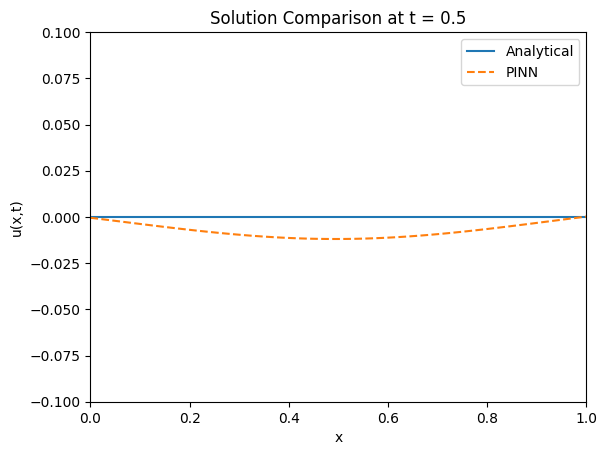

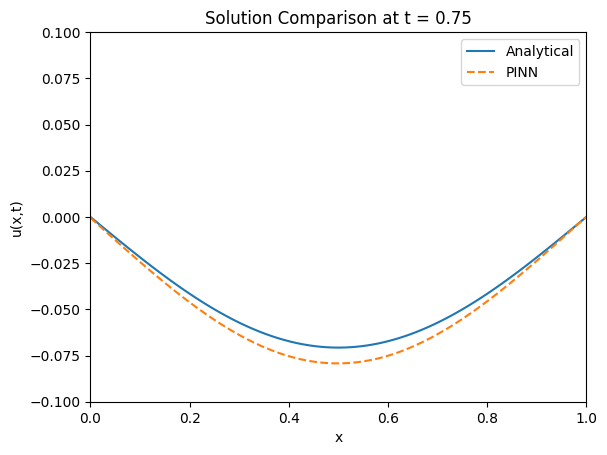

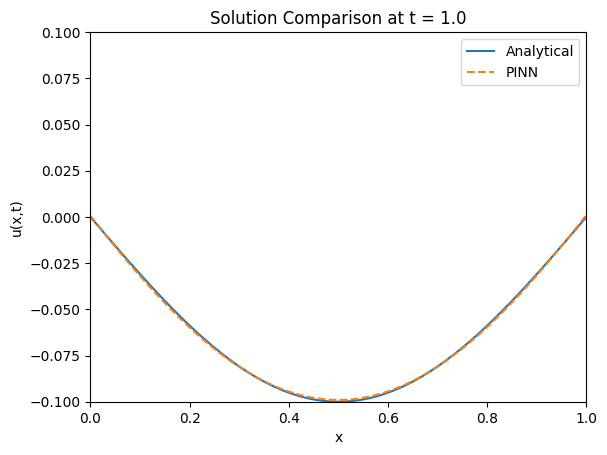

In [5]:
# Define grid and time points
nx = 100
x_vals = np.linspace(0, L, nx)
times = [0.0, 0.25, 0.5, 0.75, 1.0]

# Compute the solutions and visualize the results
L2_norm_diffs = []

for t in times:
    t_vals = t * np.ones_like(x_vals)
    inputs = np.column_stack((x_vals, t_vals))

    # Ensure inputs are in the correct shape and dtype
    inputs_tf = tf.convert_to_tensor(inputs, dtype=tf.float32)
    u_pinn = model(inputs_tf).numpy().flatten()  # Ensure model output is flattened
    u_analytical = analytical_solution(x_vals, t, L, c, A).flatten()

    # Compute the L2 norm difference
    numerator = np.sum((u_pinn - u_analytical)**2)
    denominator = np.sum(u_pinn**2)
    L2_norm_diff = np.sqrt(numerator / denominator)
    L2_norm_diffs.append(L2_norm_diff)

    # Plotting
    plt.figure()
    plt.plot(x_vals, u_analytical, label='Analytical')
    plt.plot(x_vals, u_pinn, label='PINN', linestyle='dashed')
    plt.title(f"Solution Comparison at t = {t}")
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(-0.1, 0.1)
    plt.show()

Here we evaluate the L2 norms:

In [6]:
# Print L2 norm differences
for t, diff in zip(times, L2_norm_diffs):
    print(f"L2 norm difference at t={t}: {diff}")

L2 norm difference at t=0.0: 0.012429105268883241
L2 norm difference at t=0.25: 0.14164480515624597
L2 norm difference at t=0.5: 1.000000017729473
L2 norm difference at t=0.75: 0.10328114254754844
L2 norm difference at t=1.0: 0.009934756624290565


# Improved Results with a Larger PINN Model

---

In this chapter, we will present the results obtained using a larger Physics-Informed Neural Network (PINN) model to solve the 1D wave equation. This larger model has an increased capacity due to additional layers and neurons, allowing it to potentially capture the wave dynamics more accurately than the smaller model. By comparing the predictions of this larger model with the analytical solution and the smaller model's results, we aim to demonstrate the benefits of using a more complex neural network architecture for this problem.

#### Model Setup and Checkpoint Restoration

First, we ensure the larger model's architecture is consistent with the one used during training, and we restore the model weights from the saved checkpoints. This setup is critical to accurately evaluating the model's performance.

```python
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(75, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(75, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(75, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(75, activation='tanh')
        self.dense5 = tf.keras.layers.Dense(75, activation='tanh')
        self.dense6 = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        return self.dense6(x)

# Create an instance of the PINN model
model = PINN()
```

#### Computing the Solutions and Visualizing the Results

We follow a similar procedure as in the previous chapter to compute the PINN's predictions using the larger model and compare them with the analytical solution. Additionally, we assess the improvements by comparing the L2 norm differences between the larger model's predictions and the analytical solution with those from the smaller model.

#### Analysis and Discussion

We conclude this chapter with an analysis of the larger model's performance, discussing how the increased network capacity affects the accuracy of the solution. We also highlight any observed improvements in capturing the wave dynamics and consider the computational trade-offs involved in using a larger model. This comprehensive comparison will provide valuable insights into the impact of model complexity on solving PDEs using PINNs.

In [7]:
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(75, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(75, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(75, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(75, activation='tanh')
        self.dense5 = tf.keras.layers.Dense(75, activation='tanh')
        self.dense6 = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        return self.dense6(x)

# Create an instance of the PINN model
model = PINN()


We redirect the script to the larger trained model:

In [8]:
# Weights location
checkpoint_dir = '/content/drive/My Drive/checkpoints_large'

checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint).expect_partial()
    print(f"Model restored from checkpoint: {manager.latest_checkpoint}")
else:
    print("No checkpoint found. Exiting.")
    exit()

Model restored from checkpoint: /content/drive/My Drive/checkpoints_large/ckpt-16


And we make the comparison with the larger model:

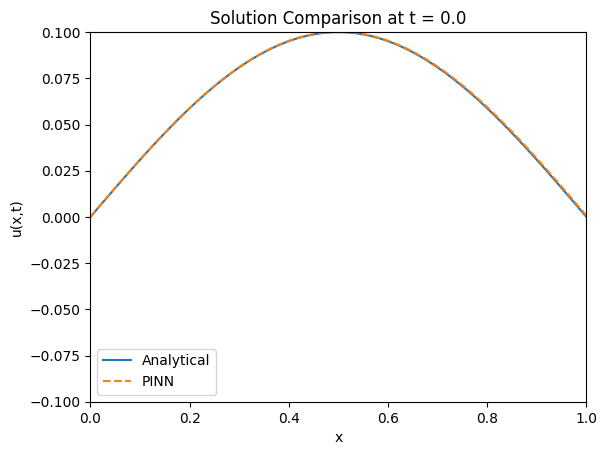

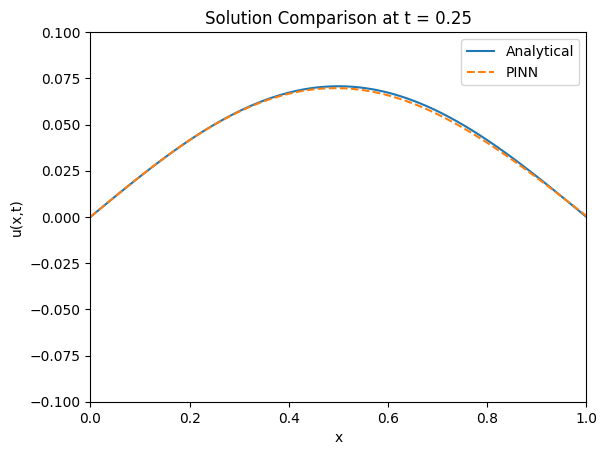

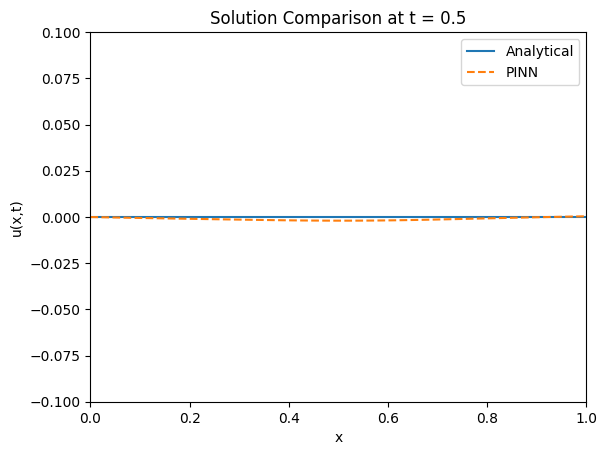

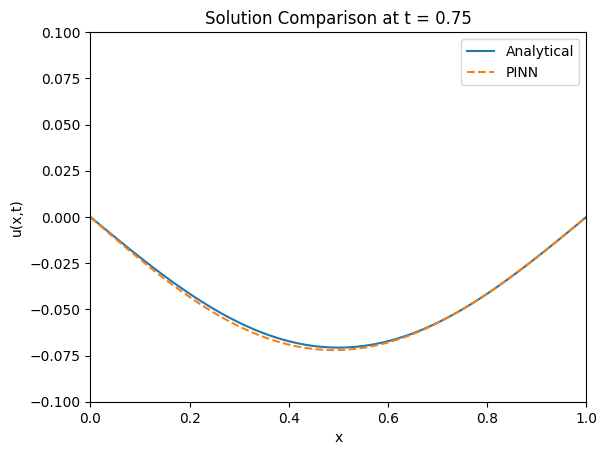

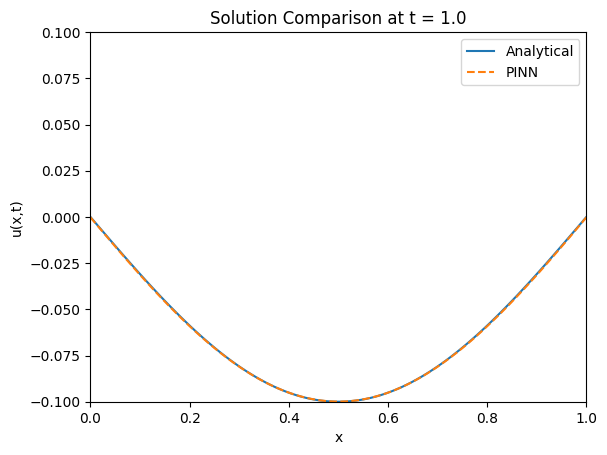

In [9]:
# Compute the solutions and visualize the results
L2_norm_diffs = []

for t in times:
    t_vals = t * np.ones_like(x_vals)
    inputs = np.column_stack((x_vals, t_vals))

    # Ensure inputs are in the correct shape and dtype
    inputs_tf = tf.convert_to_tensor(inputs, dtype=tf.float32)
    u_pinn = model(inputs_tf).numpy().flatten()  # Ensure model output is flat
    u_analytical = analytical_solution(x_vals, t, L, c, A).flatten()

    # Compute the L2 norm difference
    numerator = np.sum((u_pinn - u_analytical)**2)
    denominator = np.sum(u_pinn**2)
    L2_norm_diff = np.sqrt(numerator / denominator)
    L2_norm_diffs.append(L2_norm_diff)

    # Plotting
    plt.figure()
    plt.plot(x_vals, u_analytical, label='Analytical')
    plt.plot(x_vals, u_pinn, label='PINN', linestyle='dashed')
    plt.title(f"Solution Comparison at t = {t}")
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(-0.1, 0.1)
    plt.show()


With the corresponding L2 norms:

In [10]:
# Print L2 norm differences
for t, diff in zip(times, L2_norm_diffs):
    print(f"L2 norm difference at t={t}: {diff}")

L2 norm difference at t=0.0: 0.005461927903938444
L2 norm difference at t=0.25: 0.01924746987049145
L2 norm difference at t=0.5: 0.9999999606254641
L2 norm difference at t=0.75: 0.023562397602899597
L2 norm difference at t=1.0: 0.003934895595443941
